## 0. Setup  
   
Importing the necessary packages:

In [1]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
import pytorch_lightning as pl

## 1. Data explanation

Get the path to the h5 files and read in the data.

In [44]:
# Paths on troodon:
# fpath = "/mnt/data/feli/prototyping_data/Athaliana/h5/test_data.h5"
# gpath = "/mnt/data/feli/prototyping_data/Bdistachyon/h5/bdistachyon_test_data.h5"

# Path on Stardust:
fpath = "data/athaliana_test_data.h5" # path on home pc
gpath = "data/bdistachyon_test_data.h5" 

f = h5py.File(fpath, mode="r") # read in the h5 file
g = h5py.File(gpath, mode="r")

File architecture looks like this:

In this case the entire first file data is from the species *Arabidopsis thaliana* and the second from *Brachypodium distachyon*.   
The most important datasets (right now) are:   
- X:
    - the input/sequence data
    - the nucleotides are vectors: ``[1 0 0 0]`` is C, ``[0 1 0 0]`` is A, ``[0 0 1 0]`` is T, ``[0 0 0 1]`` is G and ``[0.25 0.25 0.25 0.25]`` is N
    - ``[0 0 0 0]`` represents padding, meaning when the sequence data is cut into chunks (here: 21384 bp), this adds "nucleotides" to get the same length no matter the length of the original sequence
- atacseq_coverage:
    - the ground truth/actual data, the network will learn to predict
    - ATAC-seq read coverage in reads per basepair

> **ATAC-seq** is short for Assay for Transposase-Accessible Chromatin using sequencing. For this assay hyperactive mutant Tn5-Transposase carrying sequencing adapter is added to cells (for example _A. thaliana_ root cells). The cells contain DNA with closed chromatin, genes there are not active, and OCRs (open chromatin regions), genes there are under active transcription. Promotors and enhancers are, when the gene is under active transription, located at OCRs. The Transposase is cutting the DNA at OCRs and ligating sequence adapters to it. These DNA fragments are then amplified, sequenced and mapped to the reference genome resulting in read coverage per basepair. 

## 2. Data preparation
The seqid list of the *A. thaliana* data has the order: Chr1, Chr2, Chr3, Chr4, Chr5, ChrM and ChrC. Since the chunks containing the mitochondrial and chloroplast genome are not useful for predicting promotors in the DNA, this data should be discarded.   
   
```python
seqids = list(f["data/seqids"])
fidx = seqids.index(b"ChrM") # first index of ChrM occurence in the list
print("Start of endosymbiont data:",fidx)
```
```
Start of endosymbiont data: 11150
```
   
In case of *B. distachyon* there are only scaffold names available, so the mitochondrial and chloroplast data cannot be identified and removed.   
   
```python
gseqids = list(g["data/seqids"])
print(set(gseqids))
```
```
{b'scaffold_12', b'Bd3', b'Bd1', b'Bd2', b'Bd4', b'scaffold_180', b'scaffold_14', b'scaffold_135', b'Bd1_centromere_containing_Bradi1g41430', b'Bd5'}
```
Since this file contains 25374 chunks (around 10 Gb of data), only a part of that will be used, so the RAM won't overflow.   
```python
print(g["data/X"])
```
```
<HDF5 dataset "X": shape (25374, 21384, 4), type "<f2">
```
Later on the endosymbiont data will not be discarded anymore, as the model will likely (hopefully) be good enough to learn not to learn from this data.

### 2.1 Dataset creation functions
Reading in input (X) and output (Y) data without the mitochondrial and chloroplast data for *A. thaliana*, which is used as the training set. Part of the *B. distachyon* data will be used as the validation set and another part as the test set. Since direct conversion from an h5 dataset (containing a ``numpy array``) to a ``pytorch tensor`` is not supported/**really** slow, the data first has to be converted to a ``numpy array``. Luckily the slicing at the end already does this (for keeping the entire dataset relacing ``[:idx]`` with ``[:]`` is the way to go).   
For the output data (Y), the last (third) dimension corresponds to the ATAC-seq coverage per bp. There are three/seven rows respectively instead of one because of the three/seven bam-files the data originates from. In order to get the total reads per bp, the rows need to be summed up.  
```python
print(f["atacseq_meta/bam_files"], g["atacseq_meta/bam_files"])
```
```
<HDF5 dataset "bam_files": shape (3,), type "|S512"> <HDF5 dataset "bam_files": shape (7,), type "|S512">
```
The datatype needs to be changed to float32 as other datatypes don't work well/at all with the built-in pytorch functions and 32-bit floats are more computationally stable anyways.   
The output (Y) is normalized using a pytorch built-in function with the formula for Euclidean norm: $ v = \frac{v}{max(∥v∥_{p},ϵ)^{.}} $  

**Function 1:**   
This first function was missing the masking of the data originating from the padded chromosome ends. A too short chunk is padded to achieve a length of 21384 basepairs. While the X data is padded with ``[0 0 0 0]``, the Y data is padded with ``-1``. This could lead to the network learning that negative read coverage exist, which is not the case. Since promotors are not at the chromosome ends anyway, this data can be excluded.   
```python
x = "data/X"
y = "evaluation/atacseq_coverage"

def h5_to_tensor(h5_dataset):
    data = torch.from_numpy(h5_dataset) # transform to tensor
    data = data.type(torch.float32) # change dtype to float32
    return data

def Y_transform(tensor):
    Y = tensor.sum(2)
    Y = F.normalize(Y) # normalize the data (to reduce bias)
    return Y

trainset = TensorDataset(h5_to_tensor(f[x][:11150]),Y_transform(h5_to_tensor(f[y][:11150])))
valset = TensorDataset(h5_to_tensor(g[x][:3000]),Y_transform(h5_to_tensor(g[y][:3000])))
testset = TensorDataset(h5_to_tensor(g[x][3000:3100]),Y_transform(h5_to_tensor(g[y][3000:3100])))
```

**Function 2** (for now with indexing to get smaller data samples):   
The ``seed_everything()`` function sets seed for pseudo-random number generators in: pytorch, numpy and python.random. The argument ``workers=True`` ensures reproducibility in the Dataloaders.

In [2]:
pl.utilities.seed.seed_everything(seed=233, workers=True)

Global seed set to 233


233

In [4]:
def h5_to_tensor(h5_data, idx1, idx2):
    data = h5_data[idx1:idx2]
    data = torch.from_numpy(data).to(torch.float32)
    return data


def create_dataset(h5_file, idx1, idx2):  # idx temporary
    x_group = "data/X"
    y_group = "evaluation/atacseq_coverage"
    X = h5_to_tensor(h5_file[x_group], idx1, idx2)
    Y = h5_to_tensor(h5_file[y_group], idx1, idx2)
    Y = Y.sum(2)
    mask = [len(y[y < 0]) == 0 for y in Y]  # exclude padded ends
    X = X[mask]
    Y = Y[mask]
    #Y = F.normalize(Y)
    #Y = torch.log(Y[mask]+1e-8)
    return TensorDataset(X, Y)

In [45]:
trainset = create_dataset(f,None,11150)
#valset = create_dataset(g,None,3000)
#testset = create_dataset(g,3000,3100)

It is also possible to save and load these datasets, so they don't have to be loaded into the jupyter environment everytime. The only downside to this is that these datasets/tensors take up a few Gb of space. For comparison: the entire h5 file of *A. thaliana* is around 600 Mb in size, only the training set, which contains only part of this file is around 5 Gb in size.   
    
```python
torch.save(trainset,"datasets/trainset.pt")
trainset = torch.load("datasets/trainset.pt")
```

Here is an example part of the **DNA input sequence**:

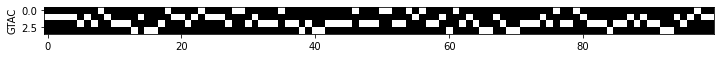

In [46]:
seq_part = trainset[0][0][200:300].T
#seq_part = seq_part.type(torch.float64) # before: dtype=float16, matplotlib needs float64

plt.figure(figsize=(12, 8))
plt.imshow(seq_part, cmap="gray")
plt.ylabel("GTAC")
plt.show()

In [48]:
print(seq_part.size())
seq_part = seq_part.view(1,4,100)

torch.Size([4, 100])


In [49]:
print(seq_part.size())

torch.Size([1, 4, 100])


In [50]:
xpad = Xpadding(100, 50, 2, 1, 9)
m = nn.Conv1d(4, 64, 9, stride=2,padding=xpad, dilation=1)
conv_seq = m(seq_part)

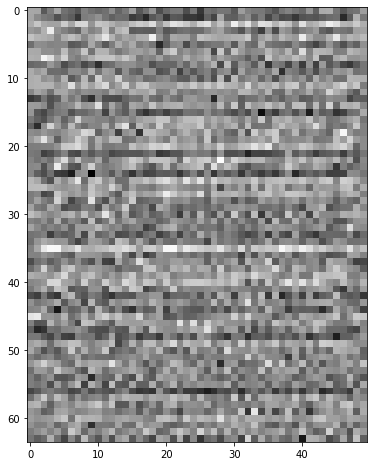

In [54]:
plt.figure(figsize=(12, 8))
plt.imshow(conv_seq.detach().view(64,50), cmap="gray")
plt.show()

### 2.1.2 Artificial Network creation:
Note: Load in the actual data beforehand.

In [6]:
# artificial input X
t = trainset[0][0][0:300]
artX = torch.chunk(t,3,dim=0)
artX = torch.stack(artX)
print(artX.size())

torch.Size([3, 100, 4])


In [7]:
C = torch.tensor([1., 0., 0., 0.])
A = torch.tensor([0., 1., 0., 0.])
T = torch.tensor([0., 0., 1., 0.])
G = torch.tensor([0., 0., 0., 1.])

In [8]:
ylist = []
for j in range(len(artX)):
    l=[]
    for i in artX[j]:
        if torch.equal(C,i):
            l.append(175)
        elif torch.equal(A,i):
            l.append(4)
        elif torch.equal(T,i):
            l.append(42)
        elif torch.equal(G,i):
            l.append(99)
    ylist.append(torch.FloatTensor(l))
print(len(ylist))

3


In [9]:
# artificial output Y
artY = torch.stack(ylist)
print(artY.size())

torch.Size([3, 100])


In [10]:
# artificial training set
art_trainset = TensorDataset(artX,artY)

In [11]:
artXval = trainset[0][0][300:400]

yval = []
for i in artXval:
    if torch.equal(C,i):
        yval.append(175)
    elif torch.equal(A,i):
        yval.append(4)
    elif torch.equal(T,i):
        yval.append(42)
    elif torch.equal(G,i):
        yval.append(99)
        
artYval = torch.FloatTensor(yval)
print(artXval.size(), artYval.size())

torch.Size([100, 4]) torch.Size([100])


In [12]:
# artificial validation data
artXval = artXval.view(1,100,4)
artYval = artYval.view(1,100)

In [13]:
# artificial validation set
art_valset = TensorDataset(artXval,artYval)

In [72]:
# Hyperparameters for the artificial data
epochs = 20
batch_size = 1
#test_batch_size = 20
cnn_layers = 2
lstm_layers = 2
lstm_units = 16 # (filter_size*2*(cnn_layers-1)) !!!!!!!!!!!!!!!!---->quatsch
linear_layers = 1 # not counting output layer
kernel_size = 5
filter_size = 16
step = 2
learning_rate = 0.001
dilation = 1 # INCLUDE WARNING: either both uneven or even dilation and kernel size (dilation still needed?)
device = "gpu"
pt_device = "cuda"
num_devices = 1

#seq_len = trainset[0][0].size(0)
seq_len=100
#nucleotides = trainset[0][0].size(1)
nucleotides=4

In [15]:
# artificial dataloaders
train_loader = DataLoader(art_trainset, batch_size=batch_size,shuffle=True,pin_memory=True, num_workers=6)
val_loader = DataLoader(art_valset, batch_size=batch_size,shuffle=False,pin_memory=True, num_workers=6)

### 2.2 Model preparations
The model hyperparameters below will in the final script, which is not going to be a notebook, be given to the program via the Python package ``argparse``.   
Right now there are a few parameters, that can not be dynamically defined yet:   
- the output size of the model (needs to always be 1)
- the optimizer algorithm
- the loss function
   
Known problems/improvements that will be applied to the python file of this network:   
- the sequence length has to be divisible by the step/steps for multiple convolutional layers
   
The hyperparameters are (for now):   
   
|Parameter          |default|Test 2|Test 3|Test 4|Test 5|Test 6|
|-------------------|-------|------|------|------|------|------|
|Epochs             |10     |100   |100   |100   |100   |100   |
|Batch size         |25     |50    |100   |100   |100   |100   |
|Test batch size    |10     |10    |20    |20    |20    |20    |
|LSTM layers        |1      |3     |4     |4     |4     |5     |
|LSTM units         |16     |64    |64    |64    |128   |128   |
|CNN layers         |1      |1     |2     |1     |1     |1     |
|Linear layers      |1      |1     |1     |3     |2     |2     |
|Kernel size        |5      |9     |9     |9     |9     |15    |
|Filter size        |16     |64    |64    |128   |128   |128   |
|Step               |4      |4     |3     |4     |6     |6     |
|Learning rate      |1e-3   |1e-3  |1e-3  |1e-3  |1e-3  |1e-3  |
|Dilation           |1      |1     |1     |1     |1     |1     |
|Sequence length    |21384  |21384 |21384 |21384 |21384 |21384 |
|Nucleotides        |4      |4     |4     |4     |4     |4     |
|**Parameter count**|3057   |106433|176641|166785|566273|701441|
|Overfit            |fail   |fail  |fail  |rip   |fail  |fail  |

In [3]:
# real model parameters
epochs = 25
batch_size = 35
test_batch_size = 20
cnn_layers = 3
lstm_layers = 1
lstm_units = 256
linear_layers = 0 # not counting output layer
kernel_size = 9
filter_size = 64
step = 2
learning_rate = 0.001
dilation = 1 # dilation still needed as parameter?
device = "gpu"
pt_device = "cuda"
num_devices = 1

#seq_len = trainset[0][0].size(0)
seq_len=21384
#nucleotides = trainset[0][0].size(1)
nucleotides=4

In [7]:
# real dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size,shuffle=True,pin_memory=True) #num_workers=6
val_loader = DataLoader(valset, batch_size=batch_size,shuffle=False,pin_memory=True)
test_loader = DataLoader(testset, batch_size=test_batch_size,shuffle=False,pin_memory=True)

Checking the GPU memory availability can be useful in some cases:   
```python
total = (torch.cuda.get_device_properties(0).total_memory/1000000)
res = (torch.cuda.memory_reserved(0)/1000000)
al = (torch.cuda.memory_allocated(0)/1000000)
free = (res-al)
print(f"GPU memory\n---------------------\ntotal: {total} Mb\nreserved: {res} Mb\nallocated: {al} Mb\nfree: {free} Mb")
```
```
GPU memory
---------------------
total: 4294.705152 Mb
reserved: 0.0 Mb
allocated: 0.0 Mb
free: 0.0 Mb
```

## 4. Neural Network Design

### 4.1 Defining the Network
**Xpadding:** To achieve the right output size of the tensor after being fed through the convolutional layer, there may need to be padding when using certain kernel sizes and strides/steps. Therefore this formula wass rearanged from the pytorch's formula to calculate L_out. The input of the convolutional layer is defined as: $(N, C_{in}, L_{in})$ and the output as: $(N, C_{out}, L_{out})$. The padding formula is: $ padding = ⌈\frac{(L_{out}-1)*stride - L_{in} + dilation*(kernelsize - 1) + 1}{2}⌉ $. (**Note**: The brackets around the equation mean the resulting number needs to be rounded up.)   
   
**Ypadding & y_pool:** Since the predicted values are pooled using the convolutional layer in the network, the target values need to be pooled too, to be able to compare them. The padding formula for the average pooling (take the average of a number of values defined by step) is: $ padding = ⌈\frac{(L_{out}-1)*stride - L_{in} + kernelsize}{2}⌉ $.   
   
**pear_coeff:** Training and validation _accuracy_ can be calculated using the pearson coefficient. Since the native implementation of this coefficient is used by concatenating the prediction and target data into one tensor, a custom function is needed to easily calculate the coefficient between prediction and target.   
   
**loss:** The loss function used for this data is the ``poisson negative log likelihood``. It is calculated using these formulas:   
```python
# for log_input=False
pnll = torch.mean(prediction-target*torch.log(prediction + eps)) # eps = 1e-8

# for log_input=True
pnll = torch.mean(torch.exp(prediction)-target*prediction)
```

In [28]:
del hybrid_model

In [4]:
def Xpadding(L_in,L_out,stride,dilation,kernel_size): 
    padding = math.ceil(((L_out-1)*stride - L_in + dilation*(kernel_size - 1) + 1)/2)
    # math.ceil to  avoid rounding half to even/bankers rounding, only needed for even L_in
    return padding

In [5]:
def Ypadding(L_in,L_out,stride,kernel_size): 
    padding = math.ceil(((L_out-1)*stride - L_in + kernel_size)/2)
    # math.ceil to  avoid rounding half to even/bankers rounding, only needed for even L_in
    return padding

In [6]:
def y_pool(target):
    for layer in range(cnn_layers):
        l_in = seq_len/step**layer
        l_out = seq_len/step**(layer + 1)
        ypad = Ypadding(l_in, l_out, step, kernel_size)
        target = F.avg_pool1d(target, kernel_size, stride=step, padding=ypad)
    return target

In [7]:
def pear_coeff(prediction, target):
    p = prediction - torch.mean(prediction)
    t = target - torch.mean(target)
    coeff = torch.sum(p*t)/(torch.sqrt(torch.sum(p**2))*torch.sqrt(torch.sum(t**2))+1e-8)
    # 1e-8 avoiding division by 0
    return coeff

In [8]:
class LitHybridNet(pl.LightningModule):
    def __init__(self, seq_len, input_size, cnn_layers, filter_size, kernel_size, step,
                 dilation, hidden_size, lstm_layers, linear_layers, output_size, learning_rate):
        super(LitHybridNet,self).__init__()
        self.seq_len = seq_len
        self.input_size = input_size
        self.cnn_layers = cnn_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.step = step
        self.dilation = dilation
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        self.linear_layers = linear_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # dummy example for model summary function in trainer
        self.example_input_array = torch.zeros(6, seq_len, input_size)
        
        # saves the hyperparameters in checkpoints if enabled
        self.save_hyperparameters()
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracy = []
        self.val_accuracy = []
        
        # CNN part:
        # -------------
        self.cnn_layer_list = nn.ModuleList()
        
        for layer in range(cnn_layers):
            l_in = seq_len/step**layer
            l_out = seq_len/step**(layer + 1)
            xpad = Xpadding(l_in, l_out, step, dilation, kernel_size)
            
            self.cnn_layer_list.append(nn.Conv1d(input_size , filter_size, kernel_size, stride=step,
                                                 padding=xpad, dilation=dilation))
            input_size = filter_size
            filter_size = filter_size*2
        
    
        # LSTM part:
        # --------------
        self.lstm = nn.LSTM(input_size=math.ceil(filter_size/2), hidden_size=hidden_size,
                            num_layers=lstm_layers, batch_first=True)
        # input: last dimension of tensor, output:(batch, sequence_length, hidden_size)
        
        # Linear part:
        # --------------
        self.linear_layer_list = nn.ModuleList()
        
        for layer in range(linear_layers):
            self.linear_layer_list.append(nn.Linear(math.ceil(filter_size/2),hidden_size))
        self.linear_layer_list.append(nn.Linear(hidden_size,output_size))
        #self.linear_layer_list.append(nn.Linear(math.ceil(filter_size/2),output_size))
    
    def forward(self,x):
        # CNN part:
        # -------------
        x = x.transpose(1,2) # convolution over the basepairs, change position of 2. and 3. dimension
        
        for layer in self.cnn_layer_list:
            x = F.relu(layer(x))

        x = x.transpose(1,2)
        
        # LSTM part:
        # --------------
        #h0 = torch.rand(self.lstm_layers, x.size(0), self.hidden_size).requires_grad_().to(pt_device)  #hidden state
        #c0 = torch.rand(self.lstm_layers, x.size(0), self.hidden_size).requires_grad_().to(pt_device)  #cell/internal state
        # size: (num_layers,batch_size,hidden_size)
        
        x,_ = self.lstm(x)  # _=(hn, cn)
        
        # Linear part:
        # --------------
        for layer in self.linear_layer_list[:-1]:
            x = F.relu(layer(x))
            
        x = self.linear_layer_list[-1](x) # !!!!
        x = x.view(x.size(0),x.size(1))
        return x
    
    def training_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        #Y = F.normalize(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        #loss = F.mse_loss(pred, Y)
        acc = pear_coeff(torch.exp(pred), Y)
        if batch_idx == (len(train_loader)-1):
            print(f"Epoch: {self.current_epoch}")
            trainP = torch.exp(pred[0]) # torch.exp()
            trainY = Y[0]
            trainP_list = trainP.view(trainP.size(0)).tolist() # convert tensor to list
            trainY_list = trainY.view(trainY.size(0)).tolist()
            plt.plot(trainP_list, label="prediction")
            plt.plot(trainY_list, label="actual_coverage")
            plt.xlabel('bp')
            plt.ylabel('coverage')
            
            plt.title("Training set")
            plt.legend()
            plt.show()
        return {"loss": loss, "acc": acc.detach()}
    
    def training_epoch_end(self, training_step_outputs):
        avg_loss = torch.stack([out["loss"] for out in training_step_outputs]).mean()
        avg_acc = torch.stack([out["acc"] for out in training_step_outputs]).mean()
        print(f"avg train loss: {avg_loss.item()}")
        print(f"avg train accuracy: {avg_acc.item()}")
        self.train_losses.append(avg_loss.item())
        self.train_accuracy.append(avg_acc.item())
        self.log("avg_train_loss", avg_loss, logger=False)
        # needs to be logged in order to be monitored by the checkpoint function of the pl.Trainer
        
    def validation_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        #Y = F.normalize(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        #loss = F.mse_loss(pred, Y)
        acc = pear_coeff(torch.exp(pred), Y)
        if batch_idx == (len(val_loader)-1):
            valP = torch.exp(pred[0]) # torch.exp()
            valY = Y[0]
            valP_list = valP.view(valP.size(0)).tolist() # convert tensor to list
            valY_list = valY.view(valY.size(0)).tolist()
            plt.plot(valP_list, label="prediction")
            plt.plot(valY_list, label="actual_coverage")
            plt.xlabel('bp')
            plt.ylabel('coverage')

            plt.title("Validation set")
            plt.legend()
            plt.show()
        return {"loss": loss, "acc": acc.detach()}
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack([out["loss"] for out in validation_step_outputs]).mean()
        avg_acc = torch.stack([out["acc"] for out in validation_step_outputs]).mean()
        print(f"avg val loss: {avg_loss.item()}")
        print(f"avg val accuracy: {avg_acc.item()}")
        self.val_losses.append(avg_loss.item())
        self.val_accuracy.append(avg_acc.item())
    
    def test_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        loss = F.poisson_nll_loss(pred, Y, log_input=True)
        acc = pear_coeff(torch.exp(pred), Y)
        metrics = {"loss": loss.item(), "acc": acc.item()}
        self.log_dict(metrics, logger=False)
        return metrics
    
    def predict_step(self, batch, batch_idx):
        X, Y = batch
        Y = y_pool(Y)
        pred = self(X)
        return {"prediction": pred, "Y": Y}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [9]:
hybrid_model = LitHybridNet(seq_len=seq_len, input_size=nucleotides, cnn_layers=cnn_layers, filter_size=filter_size,
                            kernel_size=kernel_size, step=step, dilation=dilation, hidden_size=lstm_units,
                            lstm_layers=lstm_layers, linear_layers=linear_layers, output_size=1,
                            learning_rate=learning_rate)
# dynamic output size needed?

In [10]:
print(hybrid_model)

LitHybridNet(
  (cnn_layer_list): ModuleList(
    (0): Conv1d(4, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (1): Conv1d(64, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (2): Conv1d(128, 256, kernel_size=(9,), stride=(2,), padding=(4,))
  )
  (lstm): LSTM(256, 256, batch_first=True)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)


### 4.2 Understanding Pytorch Lightning
A ``LightningModule`` organizes PyTorch code into 6 sections:
- Computations (init)
- Train Loop (training_step)
- Validation Loop (validation_step)
- Test Loop (test_step)
- Prediction Loop (predict_step)
- Optimizers and LR Schedulers (configure_optimizers)
   
There are no ``.cuda()`` or ``.to(device)`` calls required. Lightning does these on its own.
   
#### 4.2.1 Training Step
The code for the training step is:   
```python
def training_step(self, batch, batch_idx):
    X, Y = batch
    Y = y_pool(Y)
    pred = self(x)
    loss = F.poisson_nll_loss(pred, Y, log_input=True)
    return loss
```
Under the hood, this is happening during training:   
```python
# put model in train mode and enable gradient calculation
model.train()
torch.set_grad_enabled(True)

outs = []
for batch_idx, batch in enumerate(train_dataloader):
    loss = training_step(batch, batch_idx)
    outs.append(loss.detach())

    # clear gradients
    optimizer.zero_grad()

    # backward
    loss.backward()

    # update parameters
    optimizer.step()
```
It is possible to add a logging mechanism that keeps track of the loss:   
```python
def training_step(self, batch, batch_idx):
    ...
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return loss

# under the hood:
epoch_metric = torch.mean(torch.stack([x for x in outs]))
```
If something needs to be done at the end of each epoch, the method `training_epoch_end` can be overwritten:   
```python
def training_epoch_end(self, training_step_outputs):
    all_preds = torch.stack(training_step_outputs)
    ...
```   
#### 4.2.2 Validation Step
The code for the validation step is:   
```python
def validation_step(self, batch, batch_idx):
    X, Y = batch
    Y = y_pool(Y)
    pred = self(x)
    loss = F.poisson_nll_loss(pred, Y, log_input=True)
    return loss
```
Under the hood, this is happening during validation:  
```python
# ...
for batch_idx, batch in enumerate(train_dataloader):
    loss = model.training_step(batch, batch_idx)
    loss.backward()
    # ...

    if validate_at_some_point:
        # disable grads + batchnorm + dropout
        torch.set_grad_enabled(False)
        model.eval()

        # ----------------- VAL LOOP ---------------
        for val_batch_idx, val_batch in enumerate(val_dataloader):
            val_out = model.validation_step(val_batch, val_batch_idx)
        # ----------------- VAL LOOP ---------------

        # enable grads + batchnorm + dropout
        torch.set_grad_enabled(True)
        model.train()
```
For running just the validation loop:
```python
model = Model()
trainer = Trainer()
trainer.validate(model)
```
   
#### 4.3 Test Step
The test loop is only called when `test.()` is used. There are two ways to call it: 
```python
# call after training
trainer = Trainer()
trainer.fit(model)

# automatically auto-loads the best weights from the previous run
trainer.test(dataloaders=test_dataloader)

# or call with pretrained model
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
trainer.test(model, dataloaders=test_dataloader)
```
<div class="alert alert-block alert-warning">
<b>Important:</b> It is recommended to validate on single device to ensure each sample/batch gets evaluated exactly once. Otherwise, in a multi-device setting, samples could occur duplicated when DistributedSampler is used, as it replicates some samples on some devices to make sure all devices have same batch size in case of uneven inputs.</div>
    
#### 4.4 Prediction Step
The code for the predict step is:   
```python
def prediction_step(self, batch, batch_idx):
    X, Y = batch
    pred = self(X)
    return pred
```
Under the hood:   
```python
# disable grads + batchnorm + dropout
torch.set_grad_enabled(False)
model.eval()
all_preds = []

for batch_idx, batch in enumerate(predict_dataloader):
    pred = model.predict_step(batch, batch_idx)
    all_preds.append(pred)
```
There are two ways to call `predict()`:
```python
# call after training
trainer = Trainer()
trainer.fit(model)

# automatically auto-loads the best weights from the previous run
predictions = trainer.predict(dataloaders=predict_dataloader)

# or call with pretrained model
model = MyLightningModule.load_from_checkpoint(PATH)
trainer = Trainer()
predictions = trainer.predict(model, dataloaders=test_dataloader)
```

### 4.3 Model Visualization
For network visualization the model can be exported into the ``ONNX`` format.   
```python
import torch.onnx
dummy_input = torch.rand(1,21384,4).to(device)
torch.onnx.export(hybrid_model, dummy_input, "hybrid_model.onnx", input_names=["DNA Sequence"],
                  output_names=["ATACseq Read Coverage"])
```
This file can then be used with browser applications to create a ``png`` file of the network:   
- VisualDL, Link: https://www.paddlepaddle.org.cn/paddle/visualdl/demo/graph
- Netron, Link: https://github.com/lutzroeder/netron
    
It is also possible to check how many **parameters** the network has (the pytorch lightning summary function will also output a rounded number of parameters).   
```python
n = 0
for i in hybrid_model.state_dict().values():
    n += i.numel()    
print(n)
```

In [15]:
#n = 0
for i in hybrid_model.state_dict():
    print(i,":",hybrid_model.state_dict()[i].size())    


cnn_layer_list.0.weight : torch.Size([64, 4, 9])
cnn_layer_list.0.bias : torch.Size([64])
cnn_layer_list.1.weight : torch.Size([128, 64, 9])
cnn_layer_list.1.bias : torch.Size([128])
cnn_layer_list.2.weight : torch.Size([256, 128, 9])
cnn_layer_list.2.bias : torch.Size([256])
lstm.weight_ih_l0 : torch.Size([1024, 256])
lstm.weight_hh_l0 : torch.Size([1024, 256])
lstm.bias_ih_l0 : torch.Size([1024])
lstm.bias_hh_l0 : torch.Size([1024])
linear_layer_list.0.weight : torch.Size([1, 256])
linear_layer_list.0.bias : torch.Size([1])


## 5. Training

In [32]:
from pytorch_lightning.callbacks import ModelSummary, Callback, ModelCheckpoint

class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")
        
checkpoint_callback = ModelCheckpoint(save_top_k=2, monitor="avg_train_loss", mode="min",
                                      dirpath="./checkpoints",
                                      filename="hybrid_model_{epoch}_{avg_train_loss:.2f}",
                                      save_on_train_epoch_end=True)
        
callbacks = [PrintCallback(), ModelSummary(max_depth=-1), checkpoint_callback]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params | In sizes                                     | Out sizes                                   
-------------------------------------------------------------------------------------------------------------------------------------------------
0 | cnn_layer_list      | ModuleList | 371 K  | ?                                            | ?                                           
1 | cnn_layer_list.0    | Conv1d     | 2.4 K  | [6, 4, 21384]                                | [6, 64, 10692]                              
2 | cnn_layer_list.1    | Conv1d     | 73.9 K | [6, 64, 10692]                               | [6, 128, 5

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 233


avg val loss: -0.4648343324661255
avg val accuracy: 0.014455944299697876
Training is started!


Training: 0it [00:00, ?it/s]

Epoch: 0


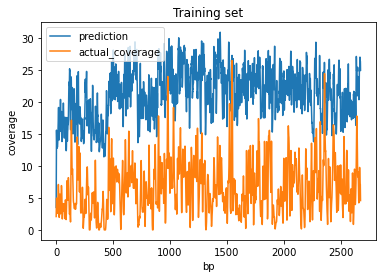

Validating: 0it [00:00, ?it/s]

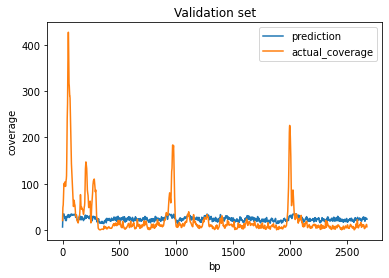

avg val loss: -92.45365905761719
avg val accuracy: 0.243105947971344
avg train loss: -53.40655517578125
avg train accuracy: 0.09305617213249207
Epoch: 1


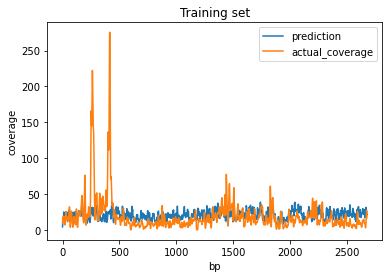

Validating: 0it [00:00, ?it/s]

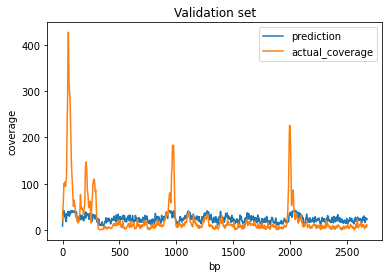

avg val loss: -93.41600799560547
avg val accuracy: 0.25043433904647827
avg train loss: -54.43787384033203
avg train accuracy: 0.13991186022758484
Epoch: 2


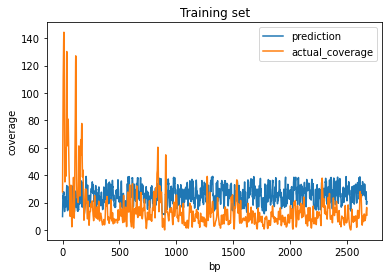

Validating: 0it [00:00, ?it/s]

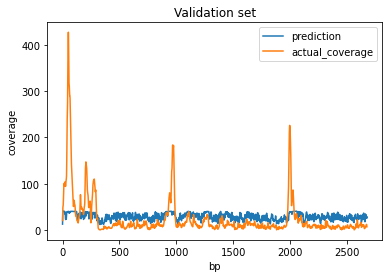

avg val loss: -94.55325317382812
avg val accuracy: 0.22783389687538147
avg train loss: -54.52894592285156
avg train accuracy: 0.17003557085990906
Epoch: 3


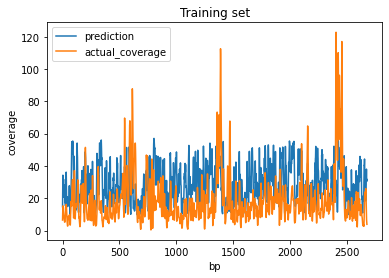

Validating: 0it [00:00, ?it/s]

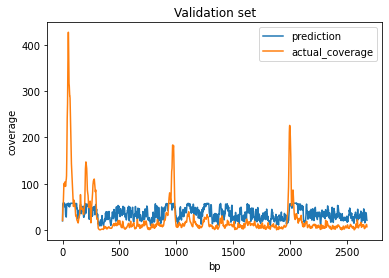

avg val loss: -95.08138275146484
avg val accuracy: 0.23326438665390015
avg train loss: -54.87497329711914
avg train accuracy: 0.1977364718914032
Epoch: 4


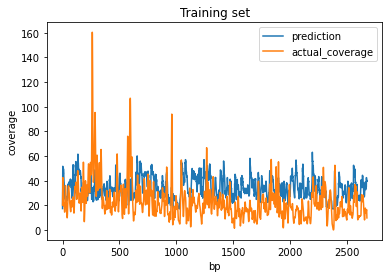

Validating: 0it [00:00, ?it/s]

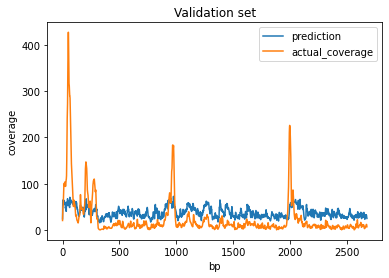

avg val loss: -94.88294982910156
avg val accuracy: 0.2532742917537689
avg train loss: -55.39124298095703
avg train accuracy: 0.23234246671199799
Epoch: 5


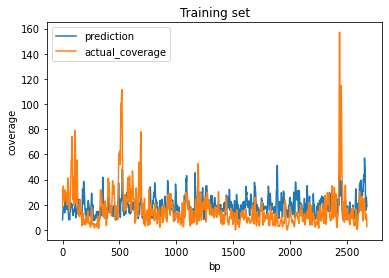

Validating: 0it [00:00, ?it/s]

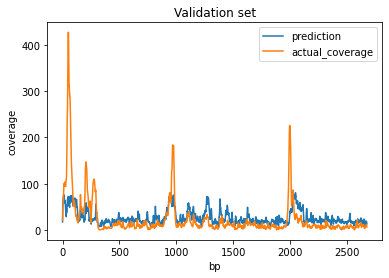

avg val loss: -94.60444641113281
avg val accuracy: 0.27220800518989563
avg train loss: -55.7193717956543
avg train accuracy: 0.2511275112628937
Epoch: 6


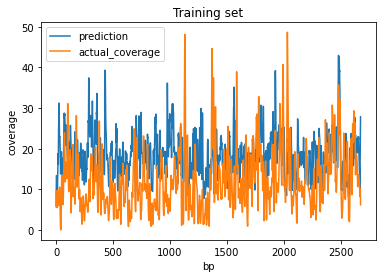

Validating: 0it [00:00, ?it/s]

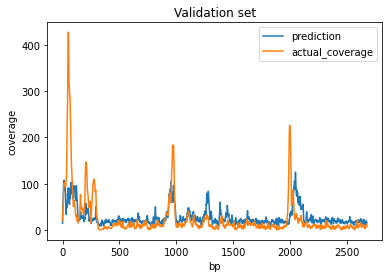

avg val loss: -93.68962097167969
avg val accuracy: 0.2795344293117523
avg train loss: -56.19522476196289
avg train accuracy: 0.27107715606689453
Epoch: 7


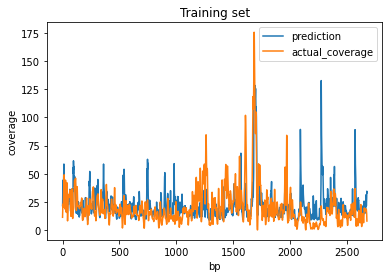

Validating: 0it [00:00, ?it/s]

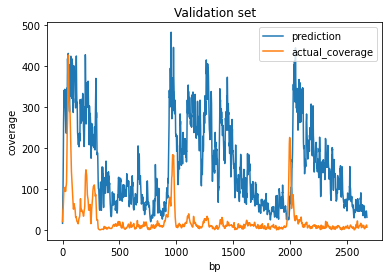

avg val loss: -3.9032464027404785
avg val accuracy: 0.1976625770330429
avg train loss: -57.026424407958984
avg train accuracy: 0.2925106883049011
Epoch: 8


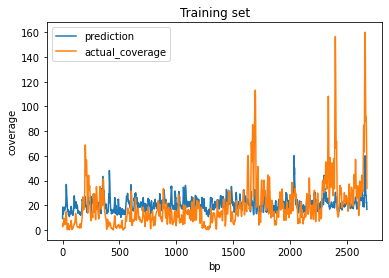

Validating: 0it [00:00, ?it/s]

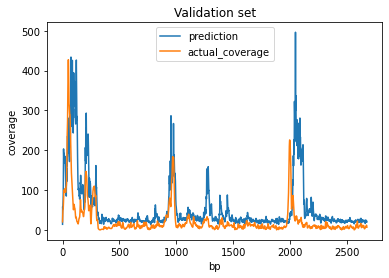

avg val loss: -74.43679809570312
avg val accuracy: 0.24664203822612762
avg train loss: -57.21503829956055
avg train accuracy: 0.2893766164779663
Epoch: 9


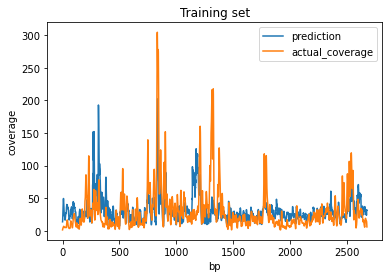

Validating: 0it [00:00, ?it/s]

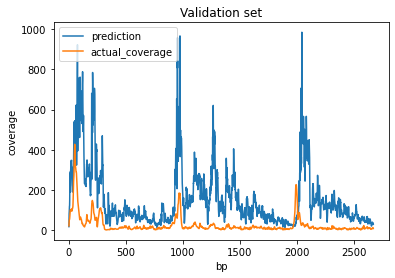

avg val loss: 34.07368469238281
avg val accuracy: 0.214378222823143
avg train loss: -57.78237533569336
avg train accuracy: 0.30100005865097046
Epoch: 10


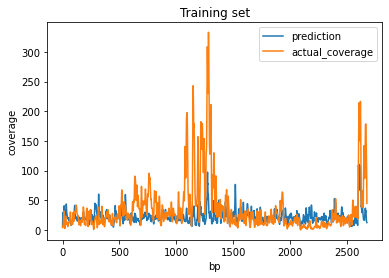

Validating: 0it [00:00, ?it/s]

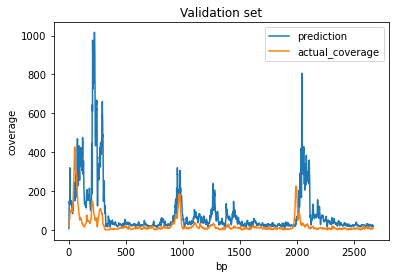

avg val loss: 41.26704025268555
avg val accuracy: 0.1964813470840454
avg train loss: -59.34713363647461
avg train accuracy: 0.3048132061958313
Epoch: 11


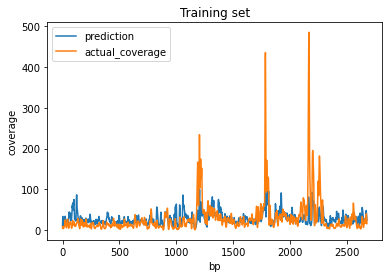

Validating: 0it [00:00, ?it/s]

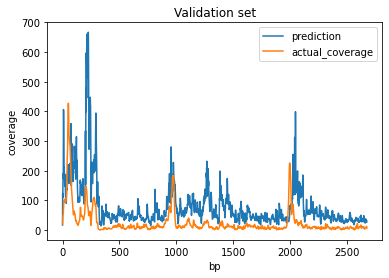

avg val loss: -46.701385498046875
avg val accuracy: 0.21608498692512512
avg train loss: -58.83403778076172
avg train accuracy: 0.31033676862716675
Epoch: 12


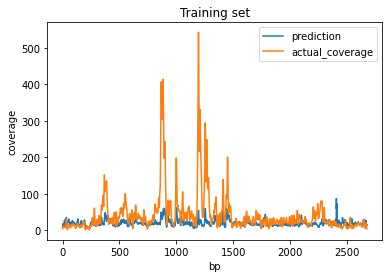

Validating: 0it [00:00, ?it/s]

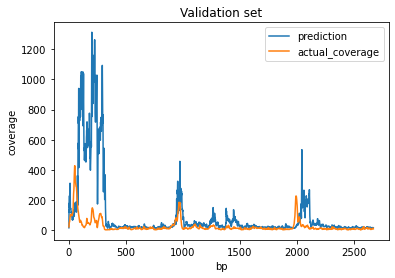

avg val loss: 42.82838439941406
avg val accuracy: 0.16358953714370728
avg train loss: -60.98978042602539
avg train accuracy: 0.3513317108154297
Epoch: 13


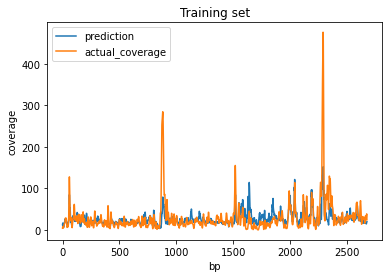

Validating: 0it [00:00, ?it/s]

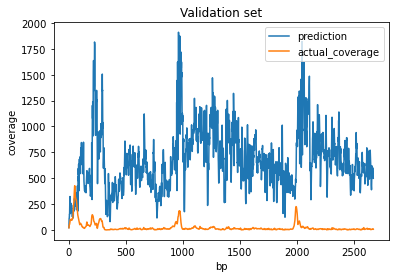

avg val loss: 468.00372314453125
avg val accuracy: 0.12098351120948792
avg train loss: -61.66637420654297
avg train accuracy: 0.36429446935653687
Epoch: 14


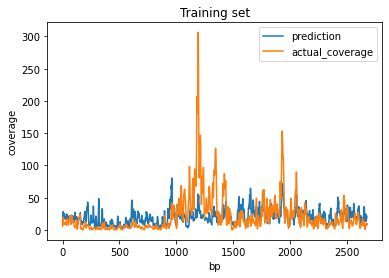

Validating: 0it [00:00, ?it/s]

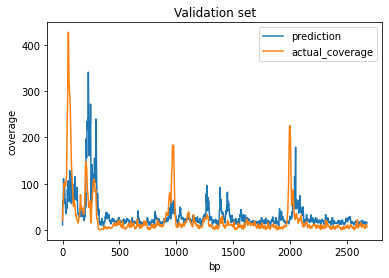

avg val loss: -81.59010314941406
avg val accuracy: 0.20393885672092438
avg train loss: -63.0272216796875
avg train accuracy: 0.39445793628692627
Epoch: 15


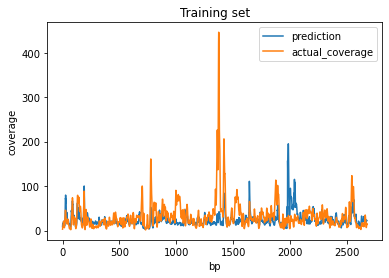

Validating: 0it [00:00, ?it/s]

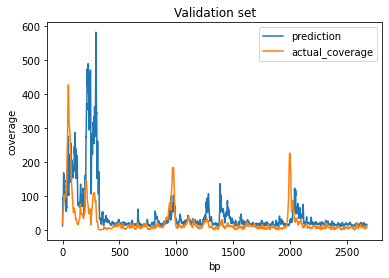

avg val loss: 15.402769088745117
avg val accuracy: 0.14271408319473267
avg train loss: -60.87643051147461
avg train accuracy: 0.3406354784965515
Epoch: 16


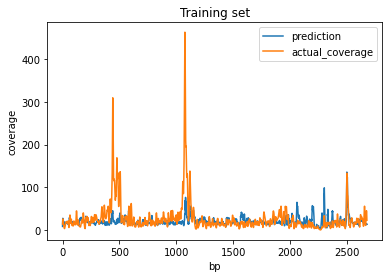

Validating: 0it [00:00, ?it/s]

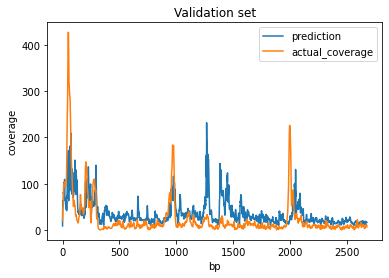

avg val loss: -84.63936614990234
avg val accuracy: 0.21938179433345795
avg train loss: -63.36191940307617
avg train accuracy: 0.4003795087337494
Epoch: 17


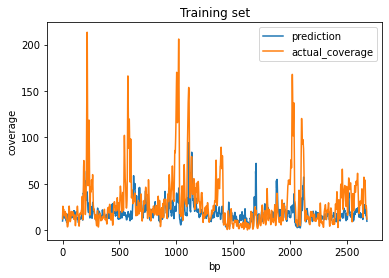

Validating: 0it [00:00, ?it/s]

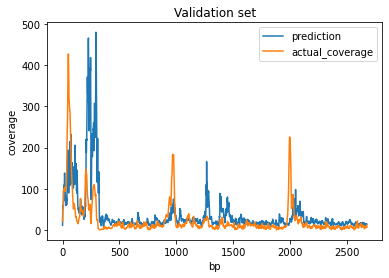

avg val loss: -43.70086669921875
avg val accuracy: 0.1615428626537323
avg train loss: -63.77360916137695
avg train accuracy: 0.41856059432029724
Epoch: 18


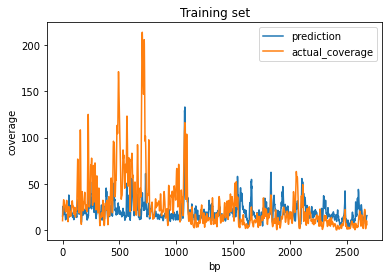

Validating: 0it [00:00, ?it/s]

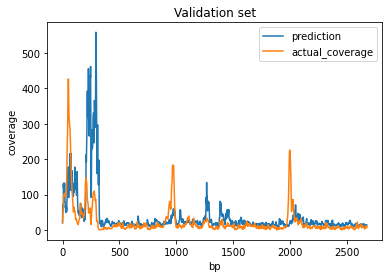

avg val loss: -57.485408782958984
avg val accuracy: 0.15559342503547668
avg train loss: -64.25262451171875
avg train accuracy: 0.43797698616981506
Epoch: 19


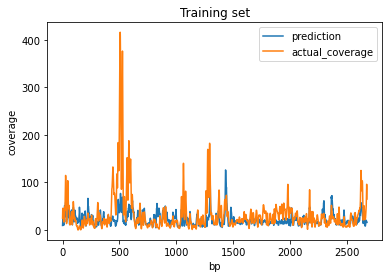

Validating: 0it [00:00, ?it/s]

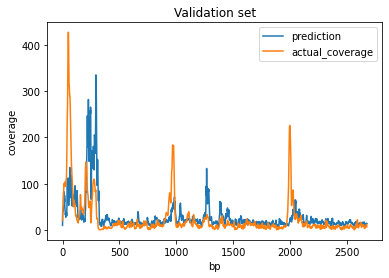

avg val loss: -74.50090026855469
avg val accuracy: 0.18149921298027039
avg train loss: -64.44881439208984
avg train accuracy: 0.44896116852760315
Epoch: 20


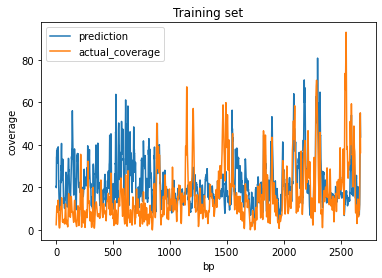

Validating: 0it [00:00, ?it/s]

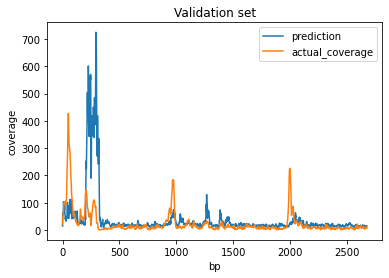

avg val loss: -68.92852020263672
avg val accuracy: 0.1670551896095276
avg train loss: -64.47915649414062
avg train accuracy: 0.45364460349082947
Epoch: 21


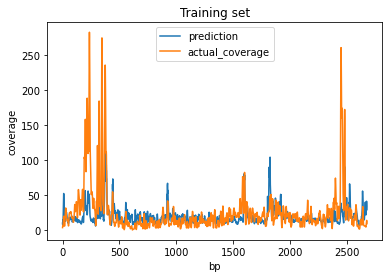

Validating: 0it [00:00, ?it/s]

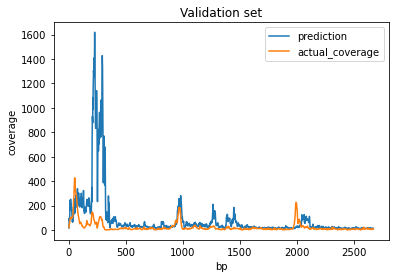

avg val loss: 48.743412017822266
avg val accuracy: 0.12905113399028778
avg train loss: -62.75454330444336
avg train accuracy: 0.40251627564430237
Epoch: 22


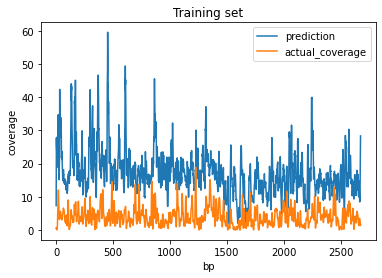

Validating: 0it [00:00, ?it/s]

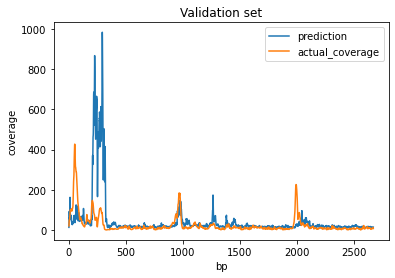

avg val loss: -50.50417709350586
avg val accuracy: 0.14561399817466736
avg train loss: -64.49659729003906
avg train accuracy: 0.4551964998245239
Epoch: 23


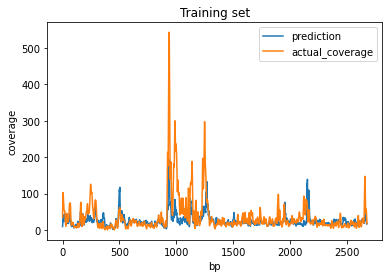

Validating: 0it [00:00, ?it/s]

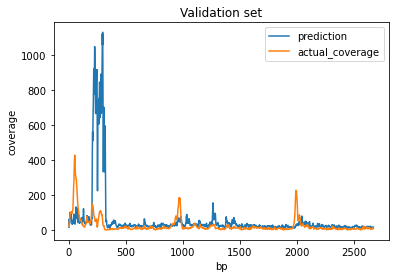

avg val loss: -54.93915939331055
avg val accuracy: 0.14234523475170135
avg train loss: -64.7240982055664
avg train accuracy: 0.4678375720977783
Epoch: 24


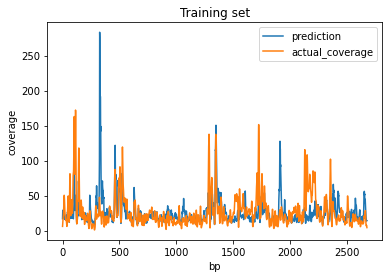

Validating: 0it [00:00, ?it/s]

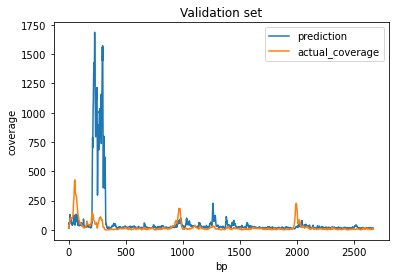

avg val loss: -62.55701446533203
avg val accuracy: 0.15773892402648926
avg train loss: -64.97990417480469
avg train accuracy: 0.4750308096408844
Training is done.


In [33]:
trainer = pl.Trainer(callbacks=callbacks, devices=num_devices, accelerator=device, max_epochs=epochs,
                     logger=False, enable_progress_bar=True, deterministic=True)
trainer.fit(model=hybrid_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# deterministic enables cudnn.deterministic, might slow training down, but ensures reproducibility

Plot of the training and validation losses:

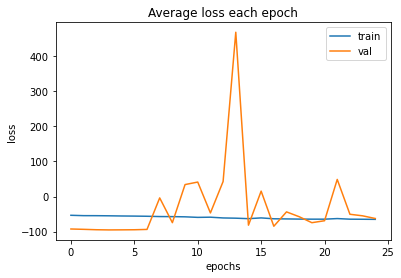

In [34]:
plt.plot(hybrid_model.train_losses, label="train")
plt.plot(hybrid_model.val_losses[1:], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.title("Average loss each epoch")
plt.legend()
plt.show()

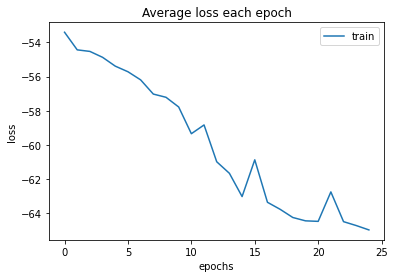

In [35]:
plt.plot(hybrid_model.train_losses, label="train")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.title("Average loss each epoch")
plt.legend()
plt.show()

Plot of the training and validation accuracies:

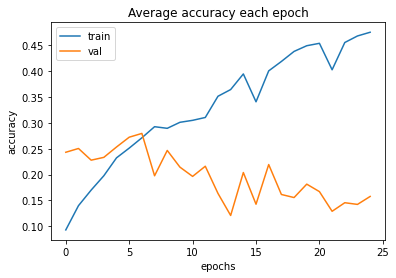

In [36]:
plt.plot(hybrid_model.train_accuracy, label="train")
plt.plot(hybrid_model.val_accuracy[1:], label="val")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.title("Average accuracy each epoch")
plt.legend()
plt.show()

## 6. Testing

In [50]:
best_model = torch.load(checkpoint_callback.best_model_path)
print(best_model['hyper_parameters'])

{'seq_len': 21384, 'input_size': 4, 'cnn_layers': 3, 'filter_size': 64, 'kernel_size': 9, 'step': 2, 'dilation': 1, 'hidden_size': 128, 'lstm_layers': 4, 'linear_layers': 1, 'output_size': 1, 'learning_rate': 0.001}


In [37]:
best_hybrid_model = hybrid_model.load_from_checkpoint("checkp/hybrid_linear_out/hybrid_model_epoch=24_avg_train_loss=-64.98.ckpt")#checkpoint_callback.best_model_path

In [38]:
trainer.test(best_hybrid_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\fkind\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc': 0.1515202671289444, 'loss': -85.17684936523438}
--------------------------------------------------------------------------------


[{'loss': -85.17684936523438, 'acc': 0.1515202671289444}]

In [39]:
predict_list = trainer.predict(best_hybrid_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\fkind\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 319it [00:00, ?it/s]

In [40]:
# for log data
mini_pred = torch.exp(predict_list[0]["prediction"][2])
pred_list = mini_pred.view(mini_pred.size(0)).tolist() # convert tensor to list
mini_cov = predict_list[0]["Y"][2]
coverage_list = mini_cov.view(mini_cov.size(0)).tolist()

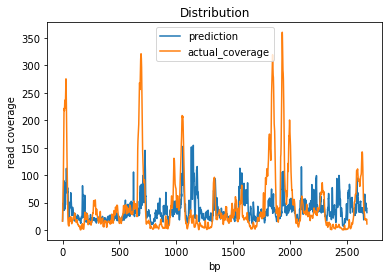

In [42]:
plt.plot(pred_list, label="prediction")
plt.plot(coverage_list, label="actual_coverage")
plt.xlabel('bp')
plt.ylabel('read coverage')

plt.title('Distribution')
plt.legend()
plt.show()

Test performance on the training set:

In [ ]:
best_hybrid_model = hybrid_model.load_from_checkpoint(checkpoint_callback.best_model_path)

In [43]:
best_hybrid_model.to(pt_device)
with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in train_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break

In [47]:
# for log data
mini_pred = torch.exp(pred[0])
pred_list = mini_pred.view(pred.size(1)).tolist() # convert tensor to list
mini_cov = coverage[0]
coverage_list = mini_cov.view(coverage.size(1)).tolist()

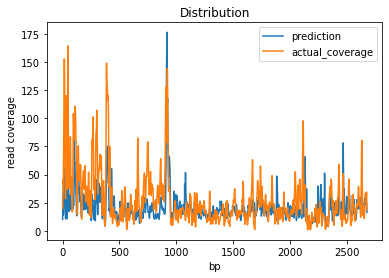

In [48]:
plt.plot(pred_list, label="prediction")
plt.plot(coverage_list, label="actual_coverage")
plt.xlabel('bp')
plt.ylabel('read coverage')

plt.title('Distribution')
plt.legend()
plt.show()

In [51]:
print(pear_coeff(pred.to(pt_device),coverage.to(pt_device)))

tensor(0.4791, device='cuda:0')


## 7. Evaluation of Server training runs
Load the loss text file and evaluate the training and validation loss.

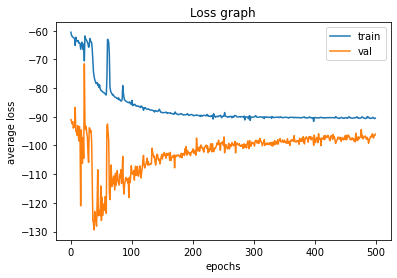

In [2]:
with open("hybrid_bigData_loss.txt", encoding="utf-8") as f:
    losses = f.readlines()
    
train_losses = [float(line.split()[1]) for line in losses[1:]]
val_losses = [float(line.split()[2]) for line in losses[1:]]

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel('epochs')
plt.ylabel('average loss')

plt.title("Loss graph")
plt.legend()
plt.show()

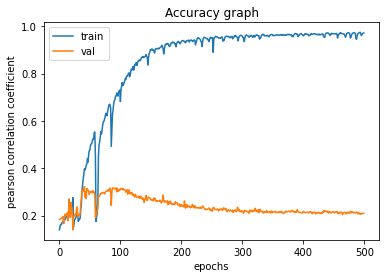

In [4]:
with open("hybrid_bigData_accuracy.txt", encoding="utf-8") as f:
    accuracies = f.readlines()
    
train_accuracy = [float(line.split()[1]) for line in accuracies[1:]]
val_accuracy = [float(line.split()[2]) for line in accuracies[1:]]

plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel('epochs')
plt.ylabel('pearson correlation coefficient')

plt.title("Accuracy graph")
plt.legend()
plt.show()

Define the model first above, with the same parameters as in the test run, then load the model weights.

In [12]:
# define hybrid net first with the same parameters or save the entire model
best_hybrid_model = hybrid_model.load_from_checkpoint("big_checkpoints/hybrid/bigData/hybrid_model_epoch=466_avg_train_loss=-91.05.ckpt")

Load a small subset of data that was used for training to check if the model under- or overfits. Load the part of the data the model has never seen, which will be the testset.

In [13]:
# Paths on troodon:
# fpath = "/mnt/data/feli/prototyping_data/Athaliana/h5/test_data.h5"
# gpath = "/mnt/data/feli/prototyping_data/Bdistachyon/h5/bdistachyon_test_data.h5"

# Path on Stardust:
fpath = "data/athaliana_test_data.h5" # path on home pc
gpath = "data/bdistachyon_test_data.h5" 

f = h5py.File(fpath, mode="r") # read in the h5 file
g = h5py.File(gpath, mode="r")

In [14]:
def h5_to_tensor(h5_data, idx1, idx2):
    data = h5_data[idx1:idx2]
    data = torch.from_numpy(data).to(torch.float32)
    return data


def create_dataset(h5_file, idx1, idx2):  # idx temporary
    x_group = "data/X"
    y_group = "evaluation/atacseq_coverage"
    X = h5_to_tensor(h5_file[x_group], idx1, idx2)
    Y = h5_to_tensor(h5_file[y_group], idx1, idx2)
    Y = Y.sum(2)
    mask = [len(y[y < 0]) == 0 for y in Y]  # exclude padded ends
    X = X[mask]
    Y = Y[mask]
    return TensorDataset(X, Y)

In [15]:
trainset = create_dataset(f,600,800)
testset = create_dataset(f, 11000,11160)

train_loader = DataLoader(trainset, batch_size=20,shuffle=False,pin_memory=True)
test_loader = DataLoader(testset, batch_size=20,shuffle=False,pin_memory=True)

**1.** Evaluate the performance on the **training set**:

In [31]:
best_hybrid_model.to(pt_device)
with torch.no_grad():
    best_hybrid_model.eval()
    for inputs,coverage in train_loader:
        pred = best_hybrid_model.forward(inputs.to(pt_device))
        coverage = y_pool(coverage)
        break

In [32]:
mini_pred = torch.exp(pred[4])
pred_list = mini_pred.view(pred.size(1)).tolist() # convert tensor to list
coverage_list = coverage[4].view(coverage.size(1)).tolist()

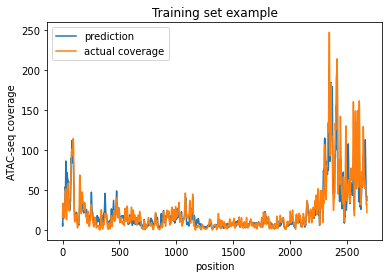

accuracy: 0.9197906255722046


In [37]:
plt.plot(pred_list, label="prediction")
plt.plot(coverage_list, label="actual coverage")
plt.xlabel('position')
plt.ylabel('ATAC-seq coverage')

plt.title('Training set example')
plt.legend()
plt.show()
print(f"accuracy: {pear_coeff(torch.exp(pred),coverage.to(pt_device))}")

**2.** Evaluate the performance on the **test set**:

In [21]:
trainer = pl.Trainer(devices=num_devices, accelerator=device, max_epochs=epochs,
                     logger=False, enable_progress_bar=True, deterministic=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [22]:
trainer.test(best_hybrid_model, dataloaders=test_loader)
predict_list = trainer.predict(best_hybrid_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\fkind\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc': 0.25576019287109375, 'loss': -227.42031860351562}
--------------------------------------------------------------------------------


C:\Users\fkind\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [38]:
# for log data
mini_pred = torch.exp(predict_list[0]["prediction"][2])
pred_list = mini_pred.view(mini_pred.size(0)).tolist() # convert tensor to list
mini_cov = predict_list[0]["Y"][2]
coverage_list = mini_cov.view(mini_cov.size(0)).tolist()

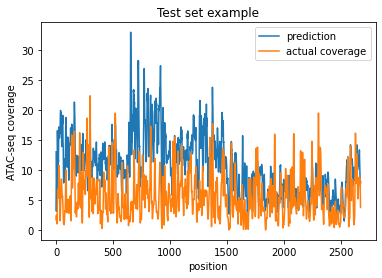

accuracy: 0.3555067479610443


In [40]:
plt.plot(pred_list, label="prediction")
plt.plot(coverage_list, label="actual coverage")
plt.xlabel('position')
plt.ylabel('ATAC-seq coverage')

plt.title('Test set example')
plt.legend()
plt.show()
print(f"accuracy: {pear_coeff(mini_pred,mini_cov)}")

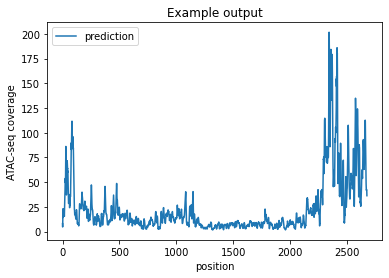

In [36]:
mini_pred = torch.exp(pred[4])
pred_list = mini_pred.view(pred.size(1)).tolist() # convert tensor to list

plt.plot(pred_list, label="prediction")
plt.xlabel('position')
plt.ylabel('ATAC-seq coverage')

plt.title('Example output')
plt.legend()
plt.show()